### Topic 8 DQ2
After reading the assigned articles and textbook chapters, how can you use exploratory data analysis techniques to uncover patterns or relationships in data that are not immediately apparent? Give an example of a dataset and explain how you would approach the task of finding hidden patterns or relationships. How can Python be used to develop a useful tool in this context?

Exploratory Data Analysis can be used to recognize patterns and relationships through visualizations and analysis. Once data is wrangles, cleaned, and processed, EDA is the step in data analysis where we get to problem solve and hypothesize. There is no right or wrong steps or visualizations to run. 

For this topic I choose a bladder cancer dataset, since I anticipate working with some kind of cancer data for my capstone as it relates to my work. 

This dataset obtained from kaggle tracks data from 294 patients across three treatment groups. EDA can help us discover what mechanisms of these drugs may be working and which drug is more effective for patients with bladder cancer. 

##### BLADDER DATA DESCRIPTIONS
	
__id__: Patient ID	

__treatment__:	Treatment received	Placebo, pyridoxine (vitamin B6), or thiotepa

__number__:	Initial number of tumors	8=8 or more

__size__:	Size (cm) of largest initial tumor	

__recur__:	Number of recurrences	

__start__:	Start time of each interval	

__stop__:	End time of each interval	

__status__:	End of interval code	0=censored, 1=recurrence, 2=death from bladder disease, 3=death other/unknown cause

__rtumor__:	Number of tumors found at recurrence	

__rsize__:	Size of largest tumor at recurrence	

__enum__:	Event number (observation number within patient)	


In [18]:
#!pip install numexpr

In [32]:
#import necessary packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson 
from math import sqrt
from statsmodels.stats.power import TTestIndPower

In [3]:
#read dataset
df = pd.read_csv('bladder1.csv')

In [4]:
#print df head
df.head()

,Unnamed: 0,id,treatment,number,size,recur,start,stop,status,rtumor,rsize,enum
0,1,1,placebo,1,1,0,0,0,3,.,.,1
1,2,2,placebo,1,3,0,0,1,3,.,.,1
2,3,3,placebo,2,1,0,0,4,0,.,.,1
3,4,4,placebo,1,1,0,0,7,0,.,.,1
4,5,5,placebo,5,1,0,0,10,3,.,.,1


In [5]:
#drop unnamed column 
df = df.drop(['Unnamed: 0'],axis=1)

In [6]:
df.describe()

,id,number,size,recur,start,stop,status,enum
count,294.000000,294.00000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000
mean,60.085034,2.37415,1.993197,3.595238,11.197279,23.795918,0.931973,2.704082
std,31.598531,1.79385,1.539011,3.022573,13.733017,15.953618,0.793832,2.092776
min,1.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,34.000000,1.00000,1.000000,1.000000,0.000000,10.000000,0.000000,1.000000
50%,61.500000,2.00000,1.000000,3.000000,4.000000,23.000000,1.000000,2.000000
75%,87.000000,3.00000,3.000000,5.000000,20.000000,36.000000,1.000000,4.000000
max,118.000000,8.00000,8.000000,9.000000,52.000000,64.000000,3.000000,10.000000


In [7]:
#check values in rtumor and rsize coumns
print(df['rtumor'].unique())
print(df['rsize'].unique())

['.' '1' '2' '3' '6' '8' '7' '5' '4']
['.' '1' '4' '2' '8' '3' '5']


In [20]:
#check dtypes
df.dtypes

id            int64
treatment    object
number        int64
size          int64
recur         int64
start         int64
stop          int64
status        int64
rtumor        int32
rsize         int32
enum          int64
dtype: object

In [9]:
# Convert '.' to 0's
df['rtumor'] = df['rtumor'].str.replace(".", "0").astype(int)
df['rsize'] = df['rsize'].str.replace(".", "0").astype(int)

<AxesSubplot:xlabel='treatment', ylabel='count'>

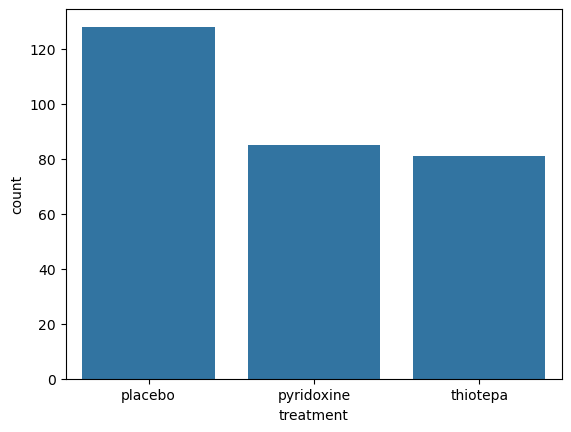

In [10]:
#find distribution of treatment 
sns.countplot(data=df,x='treatment')

The distribution of the three datasets is not even. This is something to keep in mind when doing statistical analysis.

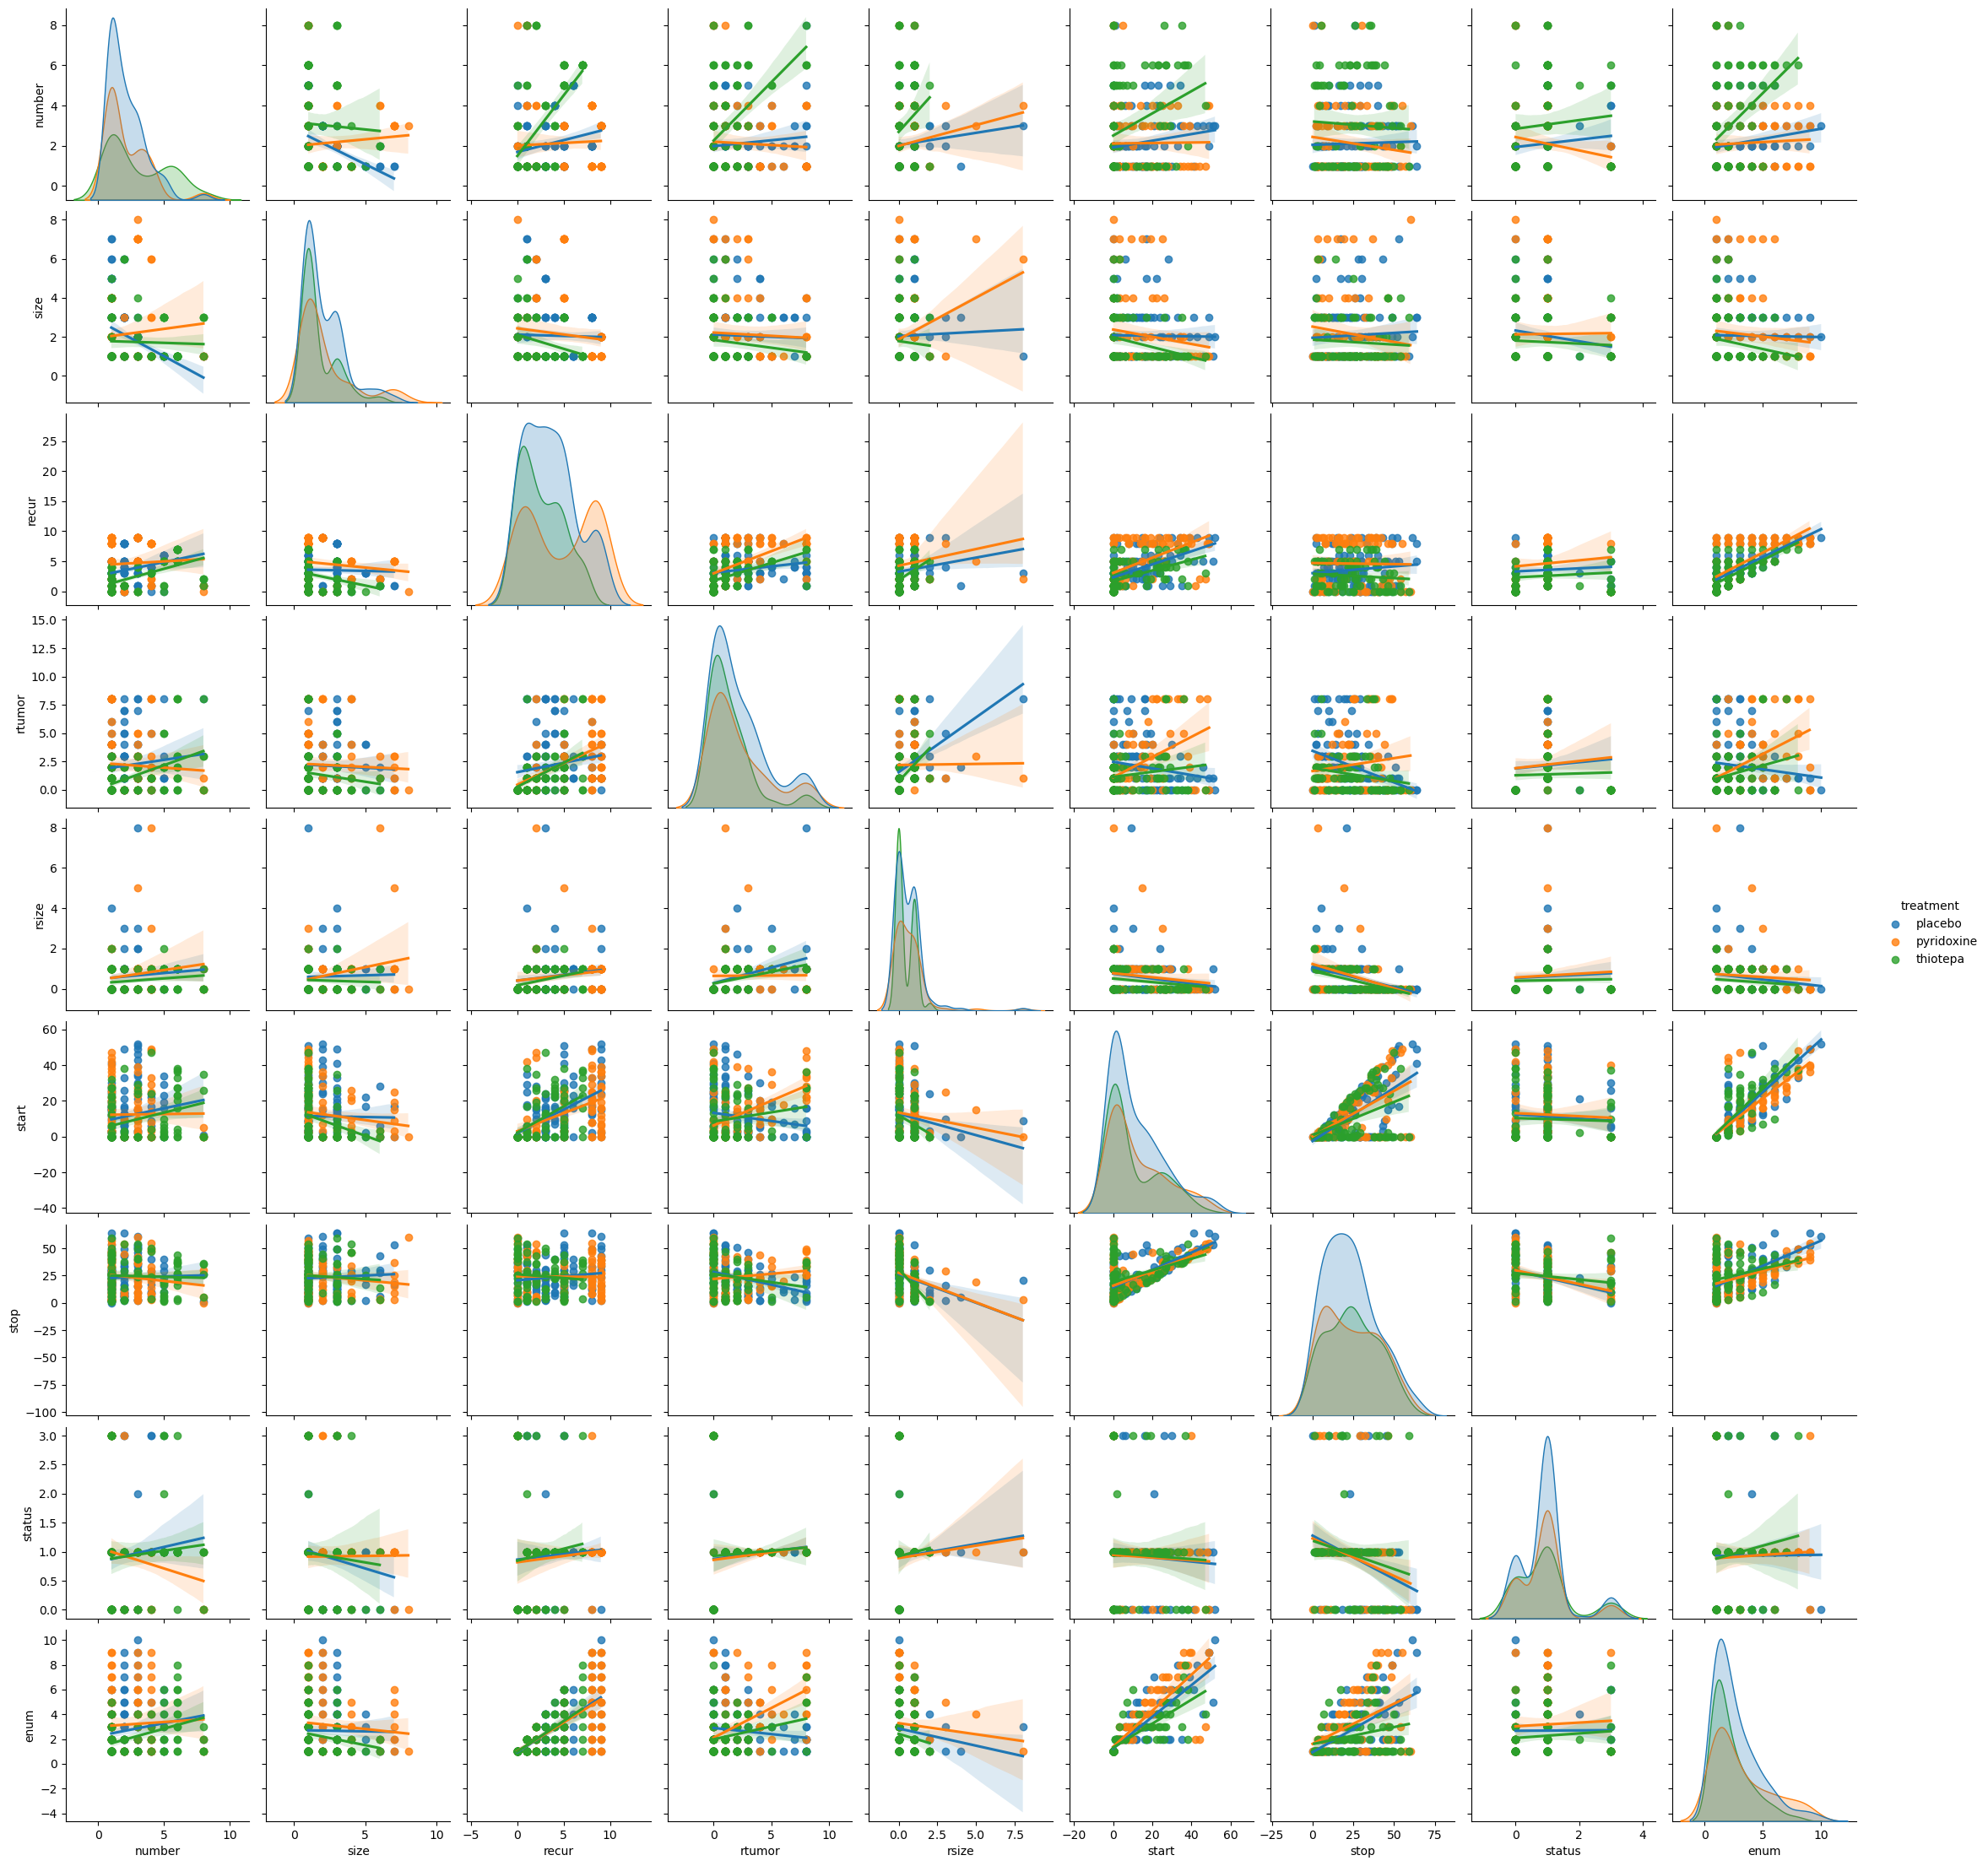

In [11]:
sns.pairplot(data = df[['number','size','recur','rtumor','rsize','treatment','start','stop','status','enum',]], 
             kind='reg',hue='treatment',corner=False)

From the pair plot we can see a few linear correlations in the dataset. One simple observation that we can make is the correlation between reoccurence and 'enum' or the number of events for a patient. The logical explanantion for this is that re-occurence requires follow up visits. 

One interesting observation is the slight negative corelation between re-occurence and tumor size for thiotepa versus the other treatments. A hypothesis that can be drawn from this, is if thiotepa causes a significant reduction in tumor size at reoccurence. 

<AxesSubplot:>

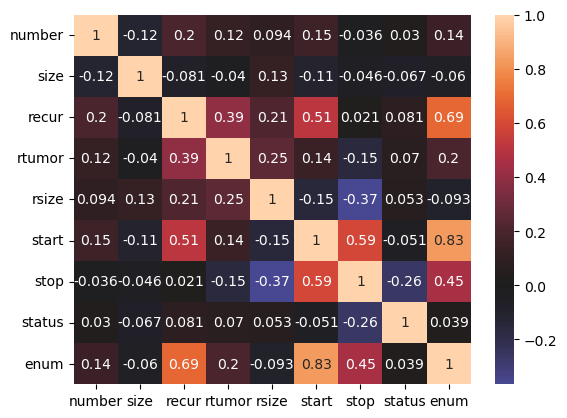

In [12]:
data= df[['number','size','recur','rtumor','rsize','start','stop','status','enum',]]
#use correlation matrix and heatmap to identify relational features
cmatrix= data.corr()
sns.heatmap(cmatrix,annot=True, center=0)

The highest correlation we see in our matrix is between number of events for a patient and reoccurence which was discussed with the pairplot data. Start and stop times of each interval are also correlated.

<AxesSubplot:xlabel='number', ylabel='count'>

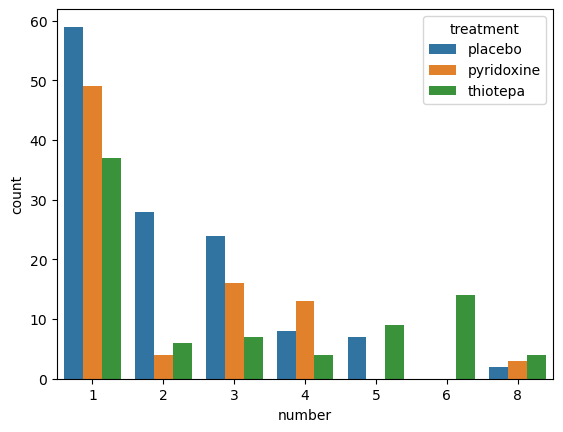

In [13]:
#plot distibution of number of tumors
sns.countplot(data=df, x='number', hue='treatment')

<AxesSubplot:xlabel='recur', ylabel='treatment'>

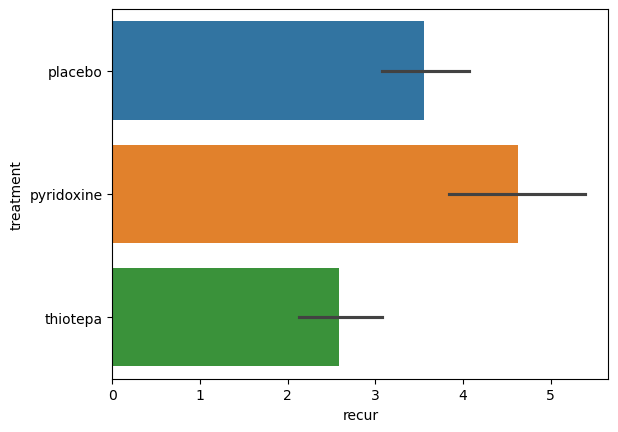

In [14]:
#plot re occurence by treatment
sns.barplot(data=df,x='recur', y='treatment', hue='treatment')

<AxesSubplot:xlabel='rsize', ylabel='treatment'>

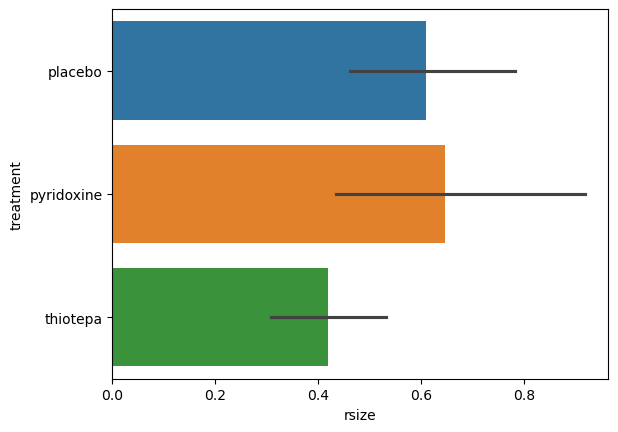

In [15]:
#plot re occurence size by treatment
sns.barplot(data=df,x='rsize',y='treatment',hue='treatment')

From the barplots above on reoccurence and reoccurent tumor sizes we can hypothesize that pyridoxine is linked to an increase in reoccurence and reoccurent tumor sizes. We can test this with anova.

In [26]:
placebo_recur = df['recur'].loc[df['treatment']=='placebo']
pyridoxine_recur= df['recur'].loc[df['treatment']=='pyridoxine']
thiotepa_recur = df['recur'].loc[df['treatment']=='thiotepa']

In [30]:
#use scipy.stats to run levene test
stats.levene(placebo_recur,pyridoxine_recur,thiotepa_recur)

LeveneResult(statistic=19.910125499405783, pvalue=7.866494902093488e-09)

In [31]:
stats.shapiro(model.resid)

ShapiroResult(statistic=0.8857409358024597, pvalue=4.88427759337811e-14)

For the assumption of linear regression and anova testing to compare means, the data does not meet assumptions. Equal variance, and normality all fall below the threshold in the case where we reject the null hypothesis. A kruskal-wallis test would then be appropriate for investigating the significance of the difference between means.

In [33]:
stats.kruskal(placebo_recur,pyridoxine_recur,thiotepa_recur)

KruskalResult(statistic=13.598317212595854, pvalue=0.0011147126655951822)

We can measure from the krusal wallis test that the difference between means is significant between treatment types for number of reoccurences.